<h1 align='center'>Neural Network Visualizer</h1>

<h2>Importing Libraries</h2>

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

<h2>Downloading Data</h2>

In [2]:
(x_train,y_train),(x_test, y_test)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


<h2>Plotting Examples</h2>

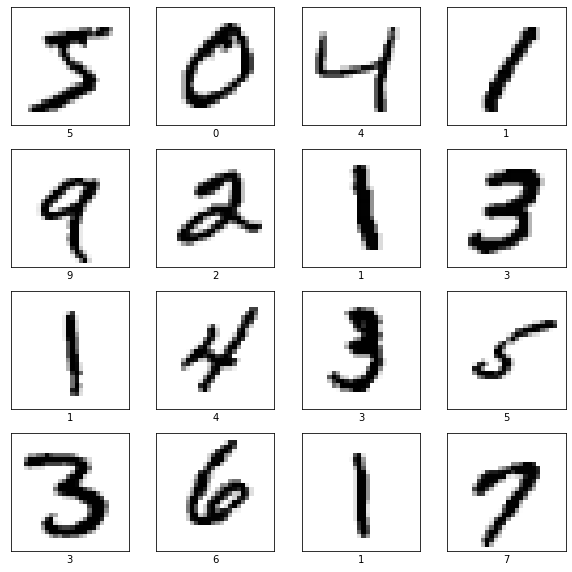

In [3]:
plt.figure(figsize=(10,10))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

<h2>Normalizing Data</h2>

In [4]:
x_train=np.reshape(x_train,(60000, 28*28))
x_test=np.reshape(x_test,(10000, 28*28))
x_train=x_train/255.
x_test=x_test/255.

<h2>Creating A Neural Network Model</h2>

In [5]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

<h2>Training the Model</h2>

In [7]:
_=model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, batch_size=128,
    verbose=2
)

Epoch 1/50
469/469 - 2s - loss: 8.6833e-04 - accuracy: 0.9999 - val_loss: 0.2755 - val_accuracy: 0.9601
Epoch 2/50
469/469 - 2s - loss: 4.8317e-04 - accuracy: 0.9999 - val_loss: 0.2752 - val_accuracy: 0.9602
Epoch 3/50
469/469 - 2s - loss: 4.1989e-04 - accuracy: 1.0000 - val_loss: 0.2758 - val_accuracy: 0.9601
Epoch 4/50
469/469 - 2s - loss: 3.8266e-04 - accuracy: 1.0000 - val_loss: 0.2758 - val_accuracy: 0.9600
Epoch 5/50
469/469 - 2s - loss: 3.5332e-04 - accuracy: 1.0000 - val_loss: 0.2761 - val_accuracy: 0.9596
Epoch 6/50
469/469 - 2s - loss: 3.2794e-04 - accuracy: 1.0000 - val_loss: 0.2773 - val_accuracy: 0.9599
Epoch 7/50
469/469 - 2s - loss: 3.0707e-04 - accuracy: 1.0000 - val_loss: 0.2773 - val_accuracy: 0.9597
Epoch 8/50
469/469 - 2s - loss: 2.8955e-04 - accuracy: 1.0000 - val_loss: 0.2781 - val_accuracy: 0.9600
Epoch 9/50
469/469 - 2s - loss: 2.7116e-04 - accuracy: 1.0000 - val_loss: 0.2788 - val_accuracy: 0.9593
Epoch 10/50
469/469 - 2s - loss: 2.5655e-04 - accuracy: 1.0000 -

<h2>Saving The Model</h2>

In [8]:
model.save('model.h5')

<h2>ML Server</h2>

In [9]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random
from flask import Flask, request
app=Flask(__name__)
model=tf.keras.models.load_model('model.h5')
feature_model=tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)
_, (x_test,_)=tf.keras.datasets.mnist.load_data()
x_test=x_test/255.
def get_prediction():
    index=np.random.choice(x_test.shape[0])
    image=x_test[index, :, :]
    image_arr=np.reshape(image,(1,784))
    return feature_model.predict(image_arr), image
@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image=get_prediction()
        final_preds=[p.tolist() for p in preds]
        return json.dumps({
            'prediction': final_preds,
            'image':image.tolist()
        })
    return 'Welcome To The Model Server!'
if __name__=='__main__':
    app.run()

Writing ml_server.py


<h2>Streamlit Web App</h2>

In [11]:
%%writefile app.py
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
URI='http://127.0.0.1:5000'
st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')
if st.button('Get Random Prediction'):
    response=requests.post(URI, data={})
    response=json.loads(response.text)
    preds=response.get('prediction')
    image=response.get('image')
    image=np.reshape(image, (28,28))
    st.sidebar.image(image, width=150)
    for layer, p in enumerate(preds):
        numbers=np.squeeze(np.array(p))
        plt.figure(figsize=(32, 4))
        if layer == 2:
            row=1
            col=10
        else:
            row=2
            col=16
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            if layer==2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Writing app.py
